In [14]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal
from numpy import array, ndarray, argsort, arange

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelBinarizer


from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart, plot_multiline_chart, plot_evaluation_results, plot_horizontal_bar_chart, HEIGHT, plot_line_chart


import seaborn as sns

from matplotlib.pyplot import figure, savefig, show, subplots


In [2]:
import pandas as pd
traf_df = pd.read_csv("traffic_accidents.csv")
traf_df.head()


,crash_date,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,07/29/2023 01:00:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,08/13/2023 12:11:00 AM,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,12/09/2021 10:30:00 AM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,08/09/2023 07:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,NONINCAPACITATING INJURY,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,08/19/2023 02:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


In [3]:
traf_target = traf_df["crash_type"] #pulling target out before dropping non-numerics

traf_features = traf_df.drop(columns=["crash_type"])

traf_features = traf_features.dropna(axis=1, how="all") # dropping empty variables col-wise
traf_features = traf_features.dropna(axis=0, how="any") #dropping rows with any missing values

traf_target = traf_target.loc[traf_features.index] #target and remaining rows aligned

traf_features = traf_features.select_dtypes(include=["number"]) #keeping only numeric cols

print(traf_features.info())
print("Features shape:", traf_features.shape)
print("Target shape:", traf_target.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   num_units                      209306 non-null  int64  
 1   injuries_total                 209306 non-null  float64
 2   injuries_fatal                 209306 non-null  float64
 3   injuries_incapacitating        209306 non-null  float64
 4   injuries_non_incapacitating    209306 non-null  float64
 5   injuries_reported_not_evident  209306 non-null  float64
 6   injuries_no_indication         209306 non-null  float64
 7   crash_hour                     209306 non-null  int64  
 8   crash_day_of_week              209306 non-null  int64  
 9   crash_month                    209306 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 16.0 MB
None
Features shape: (209306, 10)
Target shape: (209306,)


In [4]:
# train/test splitting
traf_features_train, traf_features_test, traf_target_train, traf_target_test = train_test_split(
    traf_features,
    traf_target,
    test_size=0.3,        #.7 train, .3 test
    random_state=42,      
    stratify=traf_target       # keeps class proportions similar in train and test
)

binary_map = {
    "NO INJURY / DRIVE AWAY": 0,
    "INJURY AND / OR TOW DUE TO CRASH": 1
}

traf_target_train_bin = traf_target_train.map(binary_map)
traf_target_test_bin = traf_target_test.map(binary_map)

**NAIVE BAYES ANALYSIS - TRAFFIC DATA**

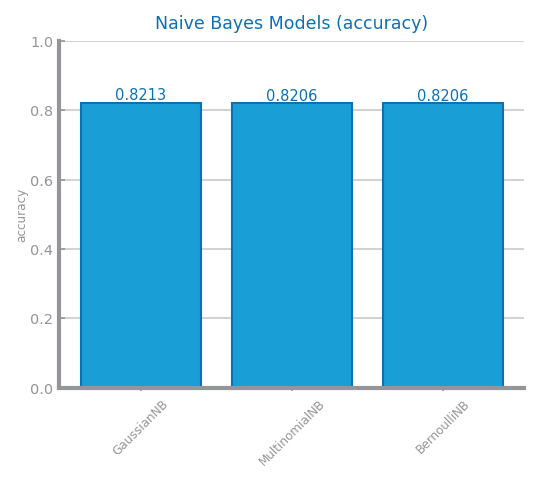

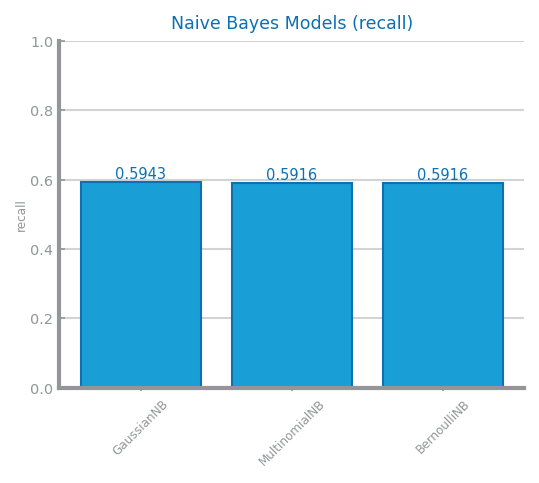

In [25]:
def naive_Bayes_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    metric: str = "accuracy"
):
    estimators = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues = []
    yvalues = []
    best_model = None
    best_params = {"name": "", "metric": metric, "params": ()}
    best_performance = 0

    for clf_name in estimators:
        xvalues.append(clf_name)
        estimators[clf_name].fit(trnX, trnY)
        prdY = estimators[clf_name].predict(tstX)
        val = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if val - best_performance > DELTA_IMPROVE:
            best_performance = val
            best_params["name"] = clf_name
            best_params[metric] = val
            best_model = estimators[clf_name]
        yvalues.append(val)

    # get Axes from DSLabs helper
    ax = plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    # remove the default labels that plot_bar_chart added
    for t in ax.texts:
        t.set_visible(False)

    # add our own labels with more precision (change .6f if you want)
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(
            f"{height:.4f}",
            (bar.get_x() + bar.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=7,
        )

    return best_model, best_params

file_tag = "traffic"
eval_metric = "accuracy"

file_tag = "traffic"
eval_metric = "accuracy"

figure()
traf_nb_best_model_acc, traf_nb_params_acc = naive_Bayes_study(
    traf_features_train,
    traf_target_train_bin,
    traf_features_test,
    traf_target_test_bin,
    metric=eval_metric
)
savefig(f"{file_tag}_nb_{eval_metric}_study.png")
show()

figure()
traf_nb_best_model_rec, traf_nb_params_rec = naive_Bayes_study(
    traf_features_train,
    traf_target_train_bin,
    traf_features_test,
    traf_target_test_bin,
    metric="recall"
)
savefig("traffic_nb_recall_study.png")
show()

<Figure size 600x450 with 0 Axes>

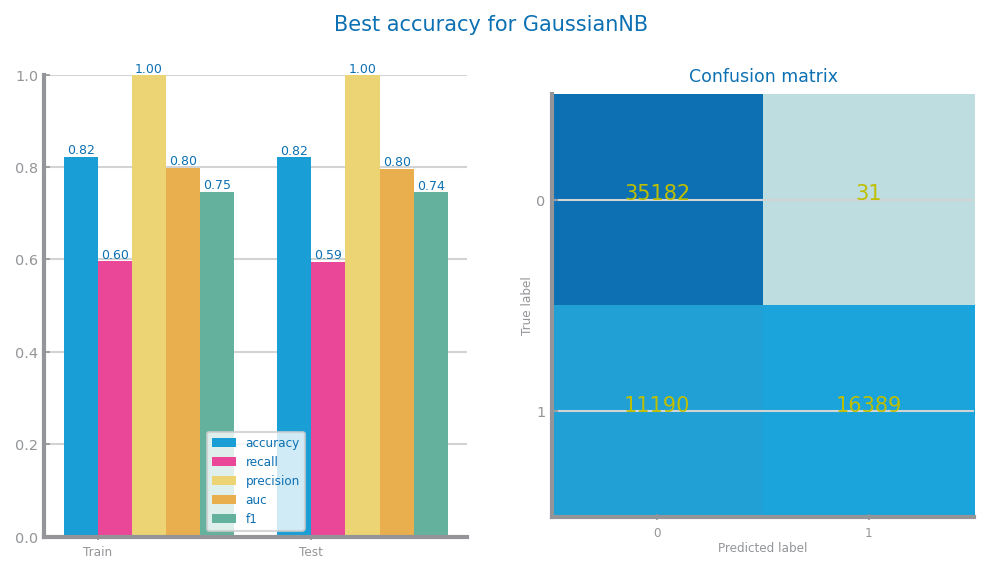

In [26]:
prd_trn_nb = traf_nb_best_model_acc.predict(traf_features_train)
prd_tst_nb = traf_nb_best_model_acc.predict(traf_features_test)

nb_labels = sorted(np.unique(traf_target_train_bin))

figure()
plot_evaluation_results(
    traf_nb_params_acc,
    array(traf_target_train_bin),
    array(prd_trn_nb),
    array(traf_target_test_bin),
    array(prd_tst_nb),
    nb_labels
)
savefig(f'traffic_{traf_nb_params_acc["name"]}_best_{traf_nb_params_acc["metric"]}_eval.png')
show()

**LOGISTIC REGRESSION ANALYSIS - TRAFFIC DATA**

LR best for 500 iterations (penalty=l1) with accuracy=0.821203


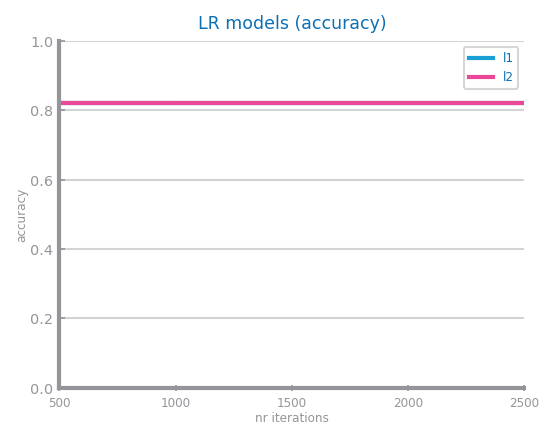

In [7]:
def logistic_regression_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
):
    nr_iterations = list(range(lag, nr_max_iterations + 1, lag))
    penalty_types = ["l1", "l2"]  # only valid with solver='liblinear'

    best_model = None
    best_params = {"name": "LR", "metric": metric, "params": ()}
    best_performance = 0.0

    values = {}
    for penalty in penalty_types:
        y_tst_values = []
        for n_iter in nr_iterations:
            clf = LogisticRegression(
                penalty=penalty,
                max_iter=n_iter,
                solver="liblinear",
                verbose=False,
            )
            clf.fit(trnX, trnY)
            prdY = clf.predict(tstX)
            val = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(val)

            if val - best_performance > DELTA_IMPROVE:
                best_performance = val
                best_params["params"] = (penalty, n_iter)
                best_model = clf

        values[penalty] = y_tst_values

    plot_multiline_chart(
        nr_iterations,
        values,
        title=f"LR models ({metric})",
        xlabel="nr iterations",
        ylabel=metric,
        percentage=True,
    )

    print(
        f'LR best for {best_params["params"][1]} iterations '
        f'(penalty={best_params["params"][0]}) with {metric}={best_performance:.6f}'
    )

    return best_model, best_params

file_tag = "traffic"
eval_metric = "accuracy"

figure()
traf_lr_best_model, traf_lr_params = logistic_regression_study(
    traf_features_train,
    traf_target_train_bin,
    traf_features_test,
    traf_target_test_bin,
    nr_max_iterations=2500,
    lag=500,
    metric=eval_metric,
)
savefig(f"{file_tag}_lr_{eval_metric}_study.png")
show()

<Figure size 600x450 with 0 Axes>

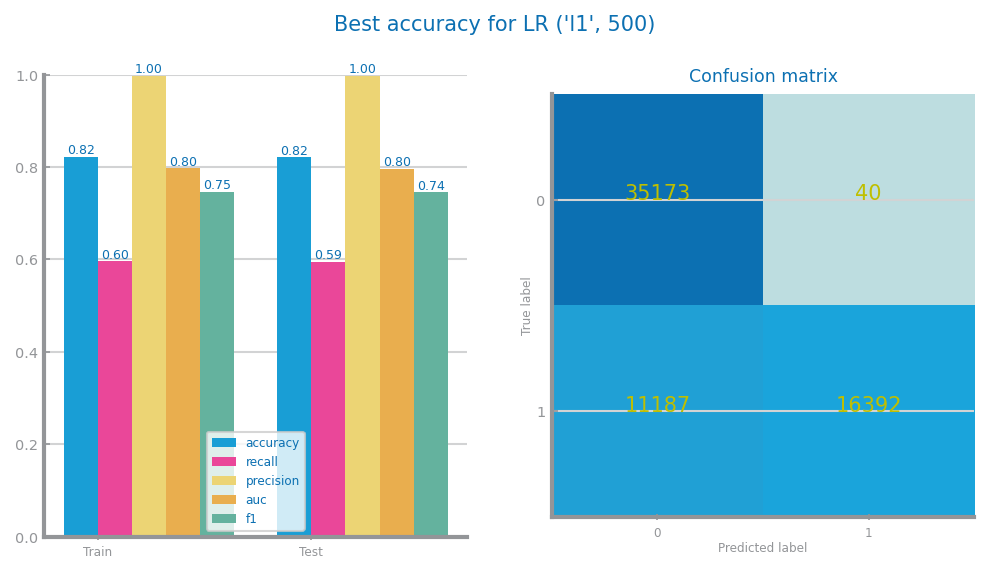

In [8]:
prd_trn_lr = traf_lr_best_model.predict(traf_features_train)
prd_tst_lr = traf_lr_best_model.predict(traf_features_test)

lr_labels = sorted(np.unique(traf_target_train_bin))

figure()
plot_evaluation_results(
    traf_lr_params,
    array(traf_target_train_bin),
    array(prd_trn_lr),
    array(traf_target_test_bin),
    array(prd_tst_lr),
    lr_labels,
)
savefig(f'traffic_{traf_lr_params["name"]}_best_{traf_lr_params["metric"]}_eval.png')
show()

**KNN ANALYSIS - TRAFFIC DATA**

KNN best with k=25 and manhattan


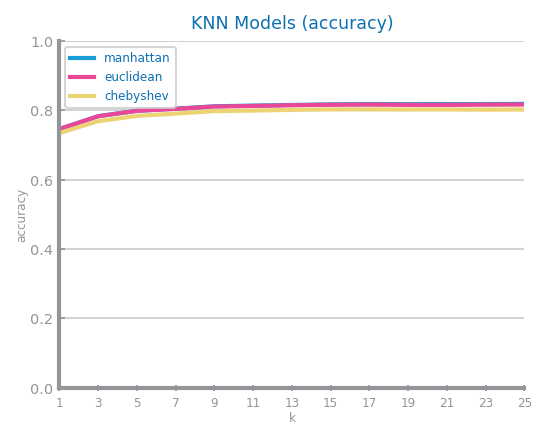

In [16]:
def knn_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    k_max: int = 19,
    lag: int = 2,
    metric: str = "accuracy",
):
    dist: list[Literal["manhattan", "euclidean", "chebyshev"]] = [
        "manhattan",
        "euclidean",
        "chebyshev",
    ]

    kvalues = [i for i in range(1, k_max + 1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params = {"name": "KNN", "metric": metric, "params": ()}
    best_performance = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY = clf.predict(tstX)
            val = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(val)
            if val - best_performance > DELTA_IMPROVE:
                best_performance = val
                best_params["params"] = (k, d)
                best_model = clf
        values[d] = y_tst_values

    print(f'KNN best with k={best_params["params"][0]} and {best_params["params"][1]}')

    plot_multiline_chart(
        kvalues,
        values,
        title=f"KNN Models ({metric})",
        xlabel="k",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params

file_tag = "traffic"
eval_metric = "accuracy"

figure()
traf_knn_best_model, traf_knn_params = knn_study(
    traf_features_train,
    traf_target_train_bin,
    traf_features_test,
    traf_target_test_bin,
    k_max=25,
    lag=2,
    metric=eval_metric,
)
savefig(f"{file_tag}_knn_{eval_metric}_study.png")
show()

<Figure size 600x450 with 0 Axes>

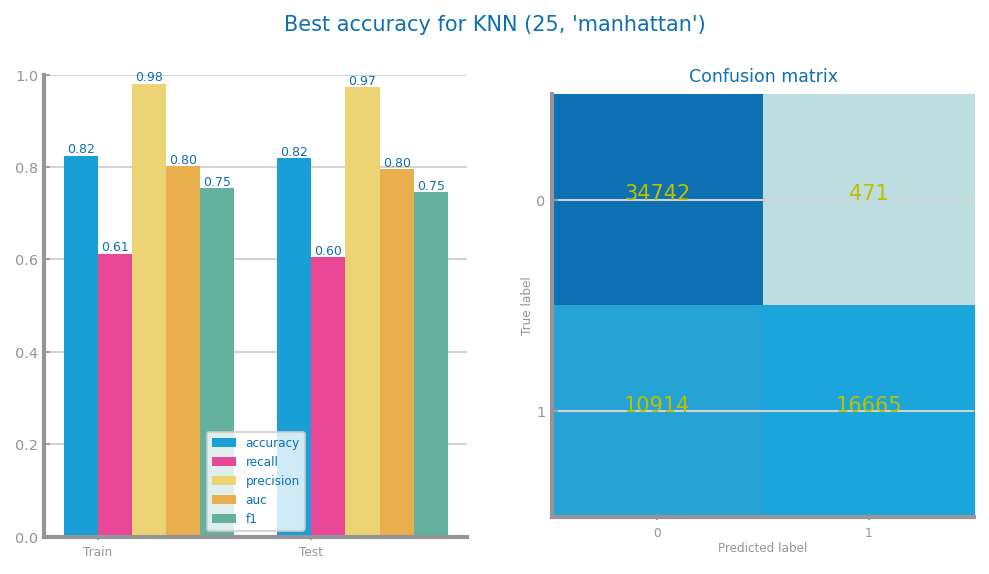

In [17]:
prd_trn_knn = traf_knn_best_model.predict(traf_features_train)
prd_tst_knn = traf_knn_best_model.predict(traf_features_test)

knn_labels = sorted(np.unique(traf_target_train_bin))

figure()
plot_evaluation_results(
    traf_knn_params,
    array(traf_target_train_bin),
    array(prd_trn_knn),
    array(traf_target_test_bin),
    array(prd_tst_knn),
    knn_labels,
)
savefig(f"traffic_{traf_knn_params['name']}_best_{traf_knn_params['metric']}_eval.png")
show()

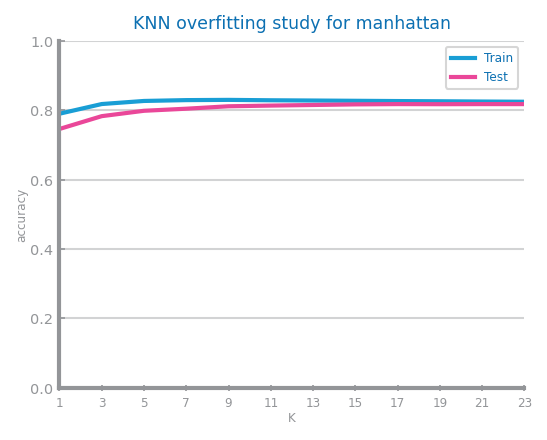

In [18]:
distance = traf_knn_params["params"][1]   # best distance from KNN study, e.g. 'euclidean'
K_MAX = 25
kvalues = [i for i in range(1, K_MAX, 2)]

y_tst_values = []
y_trn_values = []
acc_metric = "accuracy"

for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(traf_features_train, traf_target_train_bin)
    prd_tst_Y = clf.predict(traf_features_test)
    prd_trn_Y = clf.predict(traf_features_train)

    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](traf_target_test_bin, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](traf_target_train_bin, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=acc_metric,
    percentage=True,
)
savefig("traffic_knn_overfitting.png")
show()

**DECISION TREES ANALYSIS - TRAFFIC DATA**

DT best with entropy and d=6


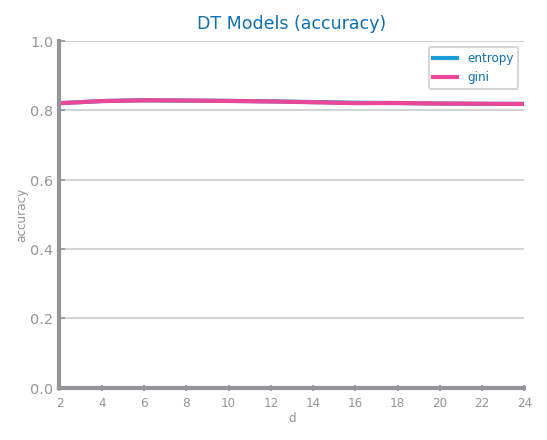

In [9]:
def trees_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    d_max: int = 10,
    lag: int = 2,
    metric: str = "accuracy",
):
    criteria = ["entropy", "gini"]
    depths = [i for i in range(2, d_max + 1, lag)]

    best_model = None
    best_params = {"name": "DT", "metric": metric, "params": ()}
    best_performance = 0.0

    values = {}
    for c in criteria:
        y_tst_values = []
        for d in depths:
            clf = DecisionTreeClassifier(
                max_depth=d,
                criterion=c,
                min_impurity_decrease=0,
                random_state=42,
            )
            clf.fit(trnX, trnY)
            prdY = clf.predict(tstX)
            val = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(val)
            if val - best_performance > DELTA_IMPROVE:
                best_performance = val
                best_params["params"] = (c, d)
                best_model = clf
        values[c] = y_tst_values

    print(f'DT best with {best_params["params"][0]} and d={best_params["params"][1]}')

    plot_multiline_chart(
        depths,
        values,
        title=f"DT Models ({metric})",
        xlabel="d",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params

file_tag = "traffic"
eval_metric = "accuracy"

figure()
traf_dt_best_model, traf_dt_params = trees_study(
    traf_features_train,
    traf_target_train_bin,
    traf_features_test,
    traf_target_test_bin,
    d_max=25,
    lag=2,
    metric=eval_metric,
)
savefig(f"{file_tag}_dt_{eval_metric}_study.png")
show()

<Figure size 600x450 with 0 Axes>

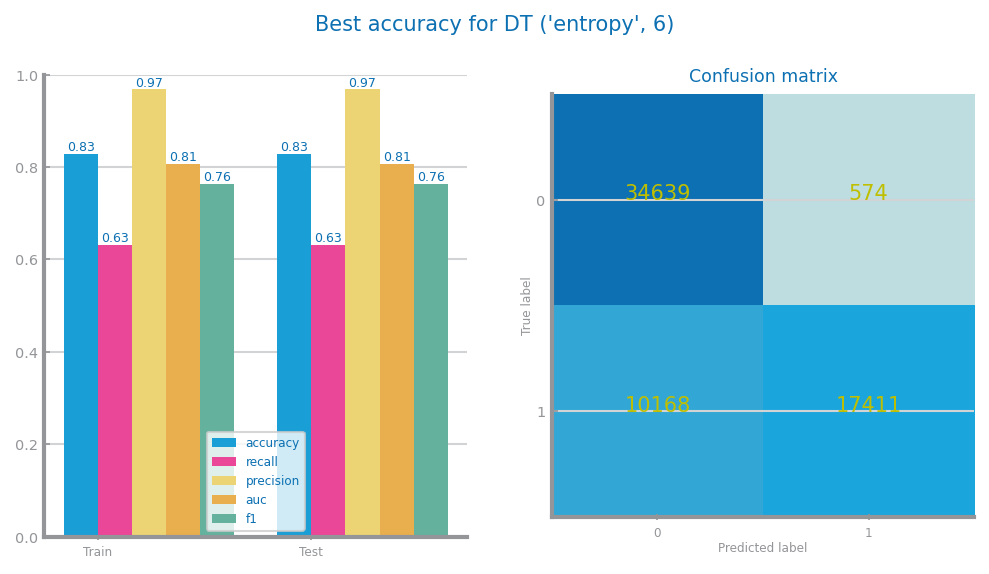

In [10]:
prd_trn_dt = traf_dt_best_model.predict(traf_features_train)
prd_tst_dt = traf_dt_best_model.predict(traf_features_test)

dt_labels = sorted(np.unique(traf_target_train_bin))

figure()
plot_evaluation_results(
    traf_dt_params,
    array(traf_target_train_bin),
    array(prd_trn_dt),
    array(traf_target_test_bin),
    array(prd_tst_dt),
    dt_labels,
)
savefig(f'traffic_{traf_dt_params["name"]}_best_{traf_dt_params["metric"]}_eval.png')
show()

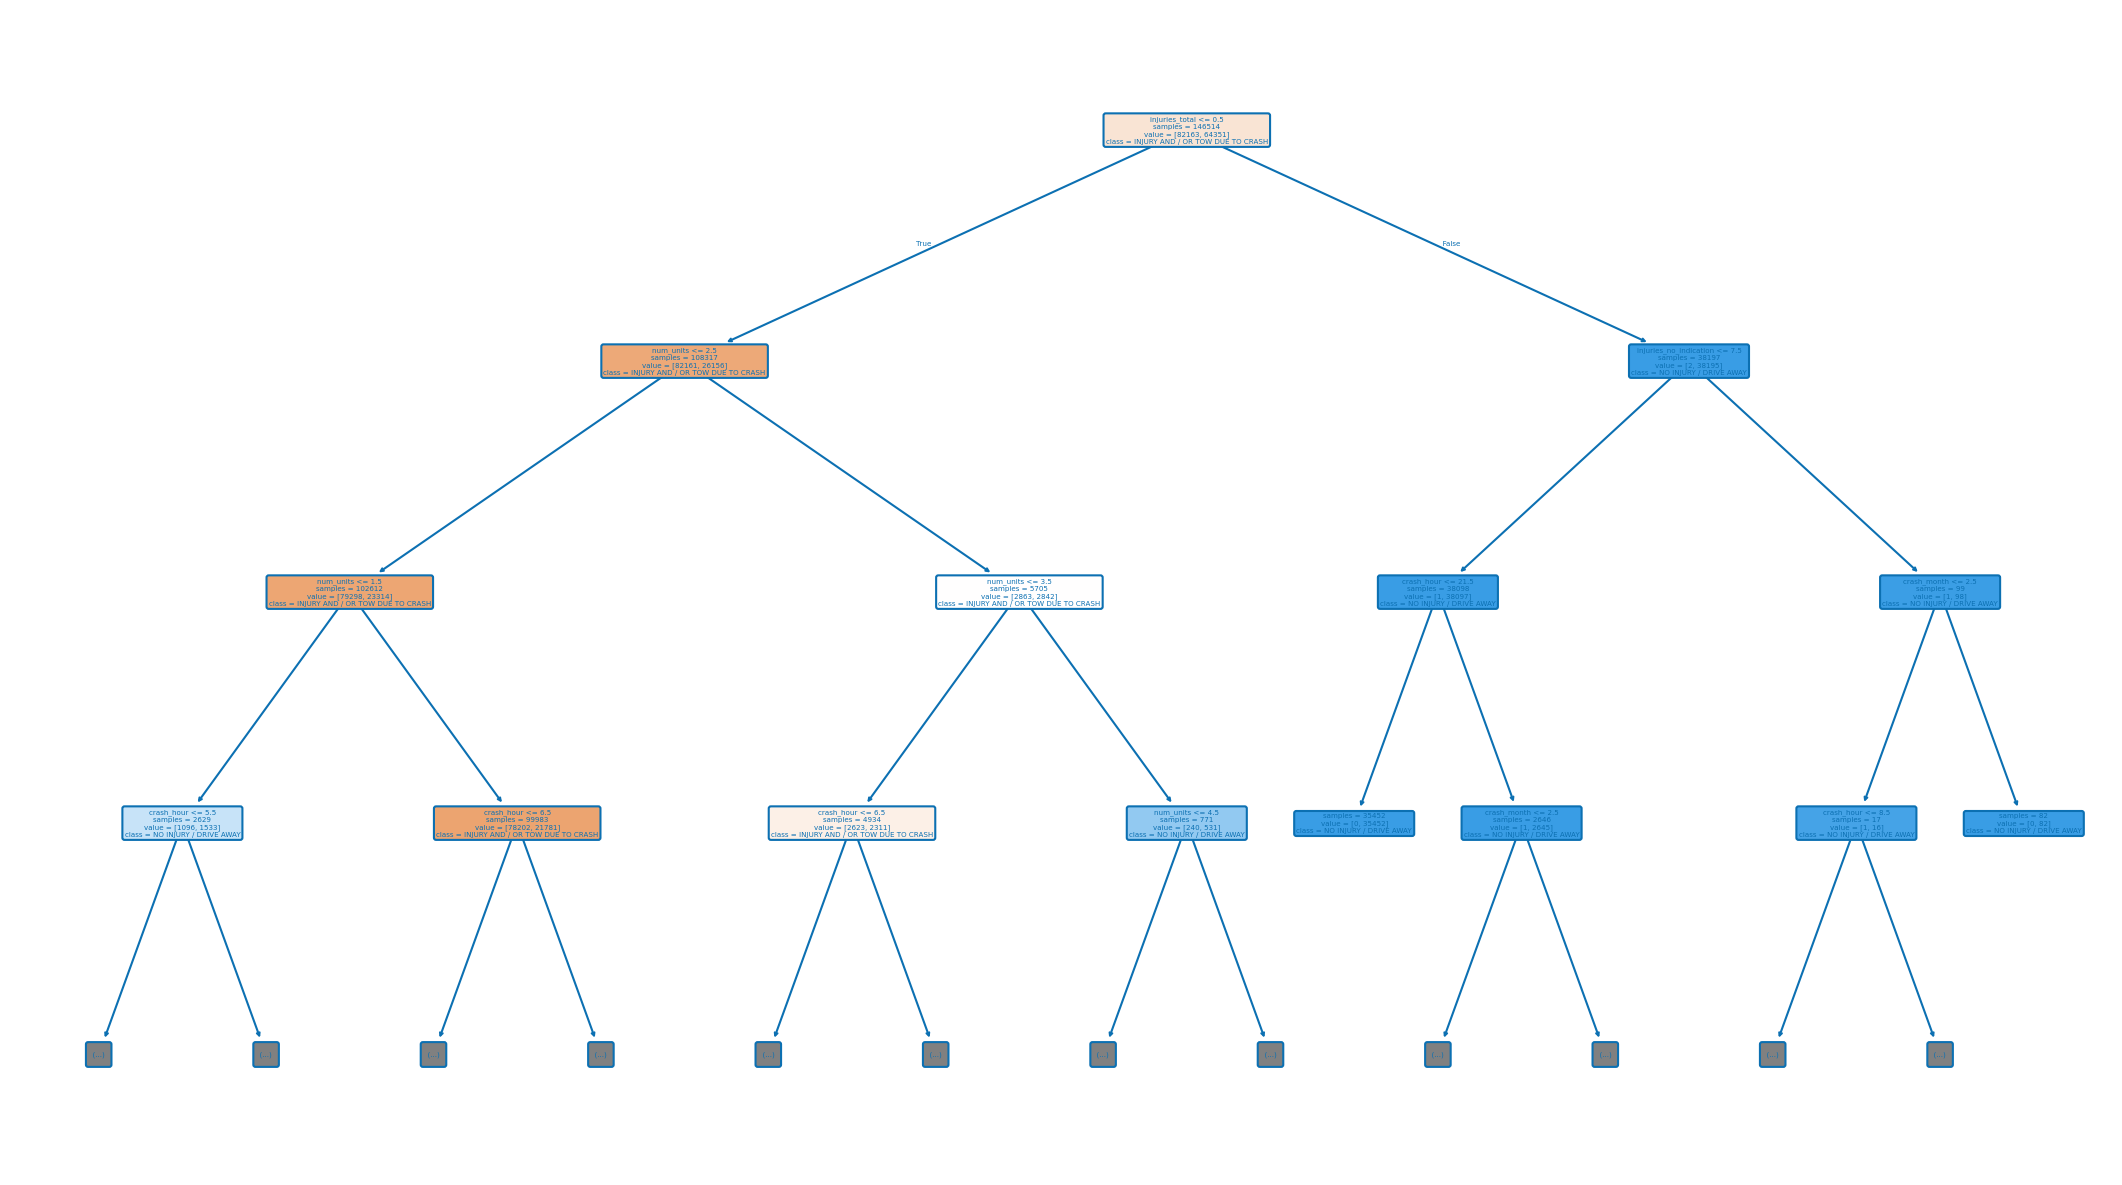

In [11]:
max_depth2show = 3   # adjust if you want deeper/shallower views
dt_feature_names = list(traf_features.columns)

dt_class_names = sorted(traf_target.unique())
tree_filename = f"traffic_dt_tree_depth{max_depth2show}"

figure(figsize=(18, 10))
plot_tree(
    traf_dt_best_model,
    max_depth=max_depth2show,
    feature_names=dt_feature_names,
    class_names=dt_class_names,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + ".png")
show()

1. injuries_total (0.9317581972135278)
2. num_units (0.04149056845320411)
3. crash_hour (0.01831341195217452)
4. injuries_no_indication (0.007586797649629394)
5. crash_day_of_week (0.0004523333225630966)
6. crash_month (0.0003986914089009333)
7. injuries_reported_not_evident (0.0)
8. injuries_non_incapacitating (0.0)
9. injuries_incapacitating (0.0)
10. injuries_fatal (0.0)


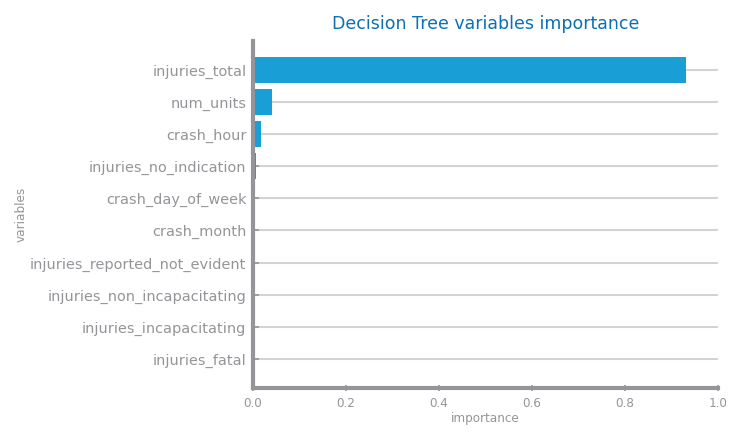

In [12]:
importances = traf_dt_best_model.feature_importances_

indices = argsort(importances)[::-1]
dt_vars = list(traf_features.columns)
elems = []
imp_values = []

# print ranked list like professor
for f in range(len(dt_vars)):
    feature_name = dt_vars[indices[f]]
    feature_imp = importances[indices[f]]

    elems.append(feature_name)
    imp_values.append(feature_imp)

    print(f"{f+1}. {feature_name} ({feature_imp})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig("traffic_dt_importance_ranking.png")
show()

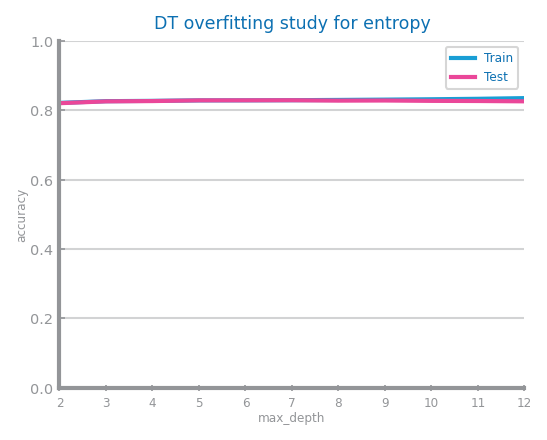

In [13]:
crit = traf_dt_params["params"][0]   # 'entropy' or 'gini'
d_max = 12
depths = [i for i in range(2, d_max + 1, 1)]

y_tst_values = []
y_trn_values = []
acc_metric = "accuracy"

for d in depths:
    clf = DecisionTreeClassifier(
        max_depth=d,
        criterion=crit,
        min_impurity_decrease=0,
        random_state=42,
    )
    clf.fit(traf_features_train, traf_target_train_bin)
    prd_tst_Y = clf.predict(traf_features_test)
    prd_trn_Y = clf.predict(traf_features_train)

    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](traf_target_test_bin, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](traf_target_train_bin, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=acc_metric,
    percentage=True,
)
savefig("traffic_dt_accuracy_overfitting.png")
show()

**MLP ANALYSIS - TRAFFIC DATA**

MLP best for 100 iterations (lr_type=constant and lr=0.05) with accuracy=0.828593


<Figure size 600x450 with 0 Axes>

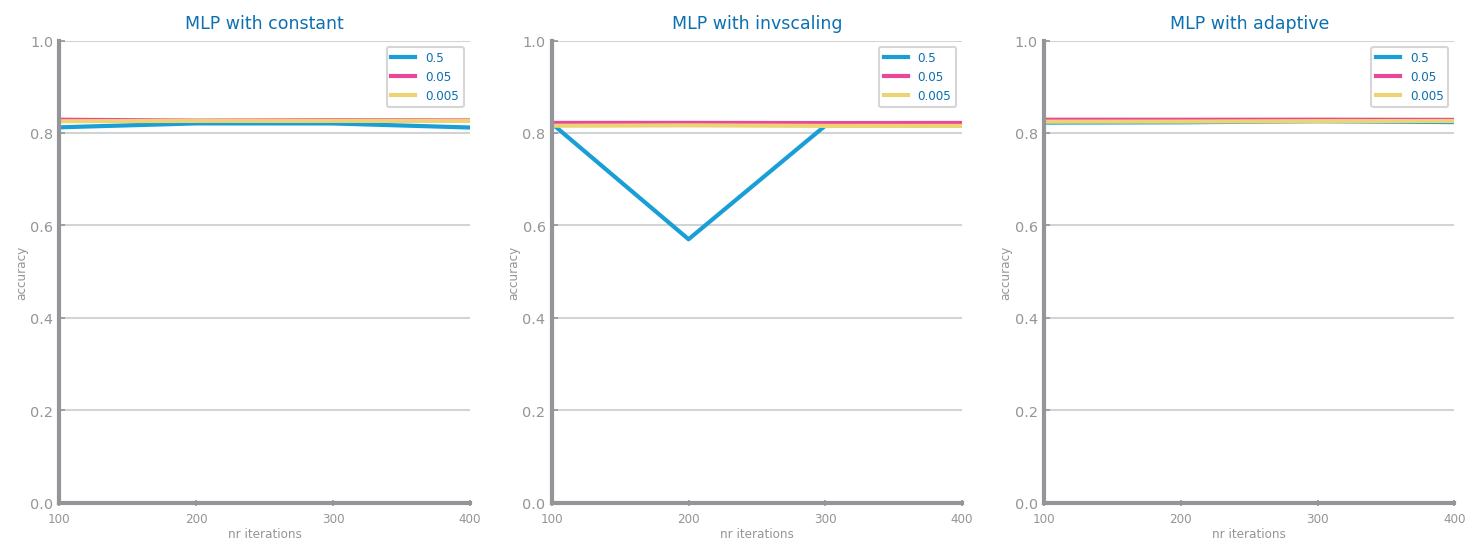

In [8]:
LAG = 100
NR_MAX_ITER = 400

def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 400,
    lag: int = 100,
    metric: str = "accuracy",
):
    nr_iterations = [lag] + [i for i in range(2 * lag, nr_max_iterations + 1, lag)]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]
    learning_rates = [0.5, 0.05, 0.005, 0.005]

    best_model: MLPClassifier | None = None
    best_params = {"name": "MLP", "metric": metric, "params": ()}
    best_performance = 0.0

    _, axs = subplots(1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False)

    for i, lr_type in enumerate(lr_types):
        values = {}
        for lr in learning_rates:
            warm_start = False
            y_tst_values = []
            for _ in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=lr_type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False,
                )
                clf.fit(trnX, trnY)
                prdY = clf.predict(tstX)
                val = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(val)
                warm_start = True
                if val - best_performance > DELTA_IMPROVE:
                    best_performance = val
                    best_params["params"] = (lr_type, lr, nr_iterations[len(y_tst_values) - 1])
                    best_model = clf
            values[lr] = y_tst_values

        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"MLP with {lr_type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )

    print(
        f'MLP best for {best_params["params"][2]} iterations '
        f'(lr_type={best_params["params"][0]} and lr={best_params["params"][1]}) '
        f'with {metric}={best_performance:.6f}'
    )

    return best_model, best_params

file_tag = "traffic"
eval_metric = "accuracy"

figure()
traf_mlp_best_model, traf_mlp_params = mlp_study(
    traf_features_train,
    traf_target_train_bin,
    traf_features_test,
    traf_target_test_bin,
    nr_max_iterations=NR_MAX_ITER,
    lag=LAG,
    metric=eval_metric,
)
savefig(f"{file_tag}_mlp_{eval_metric}_study.png")
show()

<Figure size 600x450 with 0 Axes>

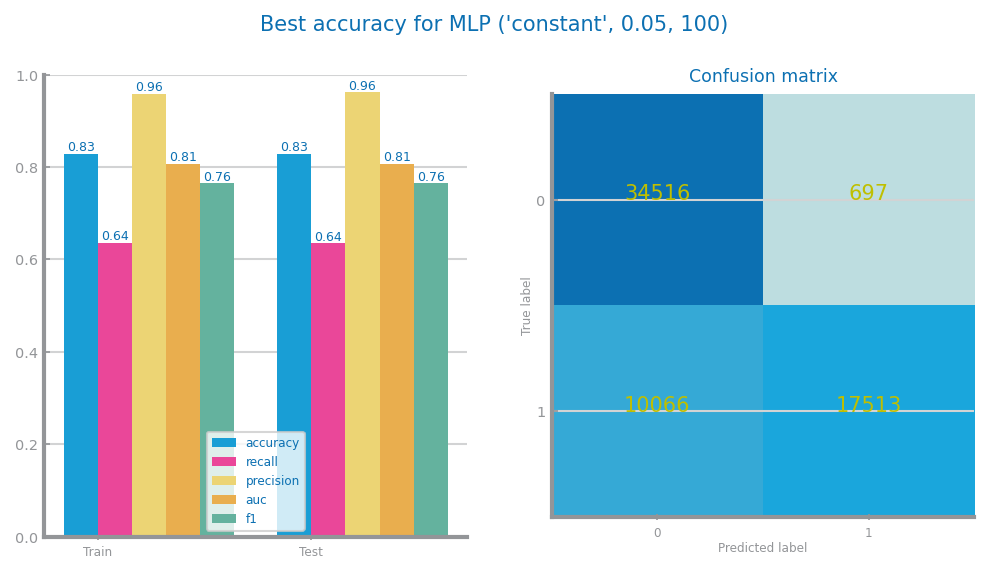

In [9]:
prd_trn_mlp = traf_mlp_best_model.predict(traf_features_train)
prd_tst_mlp = traf_mlp_best_model.predict(traf_features_test)

mlp_labels = sorted(np.unique(traf_target_train_bin))

figure()
plot_evaluation_results(
    traf_mlp_params,
    array(traf_target_train_bin),
    array(prd_trn_mlp),
    array(traf_target_test_bin),
    array(prd_tst_mlp),
    mlp_labels,
)
savefig(f"traffic_{traf_mlp_params['name']}_best_{traf_mlp_params['metric']}_eval.png")
show()

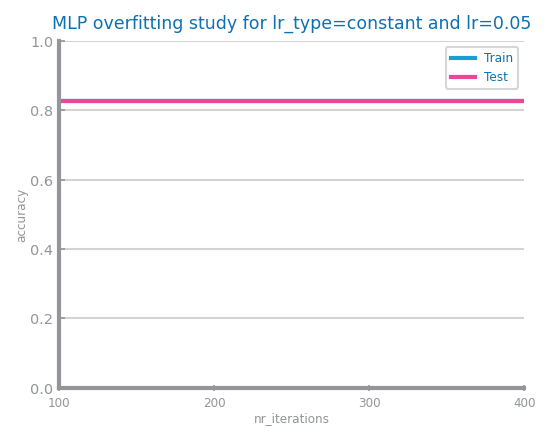

In [10]:
lr_type = traf_mlp_params["params"][0]
lr = traf_mlp_params["params"][1]

nr_iterations = [i for i in range(LAG, NR_MAX_ITER + 1, LAG)]

y_tst_values = []
y_trn_values = []
acc_metric = "accuracy"

for n in nr_iterations:
    clf = MLPClassifier(
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="adam",
        verbose=False,
        random_state=42,
    )
    clf.fit(traf_features_train, traf_target_train_bin)
    prd_tst_Y = clf.predict(traf_features_test)
    prd_trn_Y = clf.predict(traf_features_train)

    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](traf_target_test_bin, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](traf_target_train_bin, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=acc_metric,
    percentage=True,
)
savefig("traffic_mlp_accuracy_overfitting.png")
show()

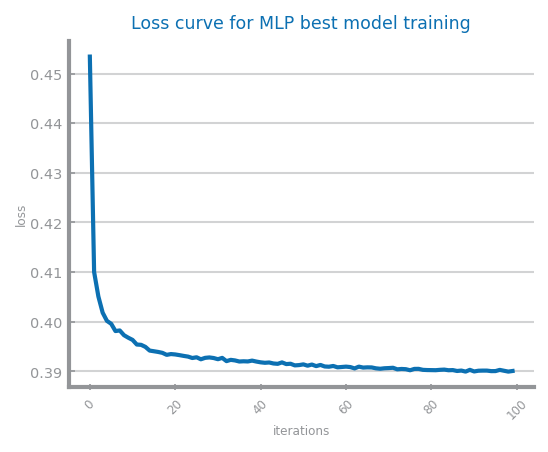

In [15]:
figure()
plot_line_chart(
    arange(len(traf_mlp_best_model.loss_curve_)),
    traf_mlp_best_model.loss_curve_,
    title="Loss curve for MLP best model training",
    xlabel="iterations",
    ylabel="loss",
    percentage=False,
)
savefig(f"{file_tag}_mlp_{eval_metric}_loss_curve.png")
show()

In [20]:
flight_df = pd.read_csv("Combined_Flights_2022.csv")
flight_df.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",GJT,DEN,False,False,1133,1123.0,0.0,-10.0,...,1140.0,1220.0,8.0,1245,-17.0,0.0,-2.0,1200-1259,1,0
1,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",HRL,IAH,False,False,732,728.0,0.0,-4.0,...,744.0,839.0,9.0,849,-1.0,0.0,-1.0,0800-0859,2,0
2,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1529,1514.0,0.0,-15.0,...,1535.0,1622.0,14.0,1639,-3.0,0.0,-1.0,1600-1659,2,0
3,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",IAH,GPT,False,False,1435,1430.0,0.0,-5.0,...,1446.0,1543.0,4.0,1605,-18.0,0.0,-2.0,1600-1659,2,0
4,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1135,1135.0,0.0,0.0,...,1154.0,1243.0,8.0,1245,6.0,0.0,0.0,1200-1259,2,0


In [21]:
flight_target = flight_df["Cancelled"]
flight_features = flight_df.drop(columns=["Cancelled"])

flight_features = flight_features.dropna(axis=1, how="all") #drops all cols with all NaN

flight_features = flight_features.dropna(axis=1, how="any") #drops all cols with any NaN

flight_target = flight_target.loc[flight_features.index]

flight_features = flight_features.select_dtypes(include=["number"])

print("Final target distribution:")
print(flight_target.value_counts(dropna=False))

Final target distribution:
Cancelled
False    3955126
True      123192
Name: count, dtype: int64


In [23]:
sample_size = 200000  # smaller because data set is huge, models take too long

flight_features_sampled = flight_features.sample(n=sample_size, random_state=42)
flight_target_sampled = flight_target.loc[flight_features_sampled.index]

print("\nSampled features shape:", flight_features_sampled.shape)
print("Sampled target distribution:")
print(flight_target_sampled.value_counts(dropna=False))

flight_features_train, flight_features_test, flight_target_train, flight_target_test = train_test_split(
    flight_features_sampled,
    flight_target_sampled,
    test_size=0.3,
    random_state=42,
    stratify=flight_target_sampled
)


Sampled features shape: (200000, 25)
Sampled target distribution:
Cancelled
False    194064
True       5936
Name: count, dtype: int64


**NAIVE BAYES ANALYSIS - FLIGHT DATA**

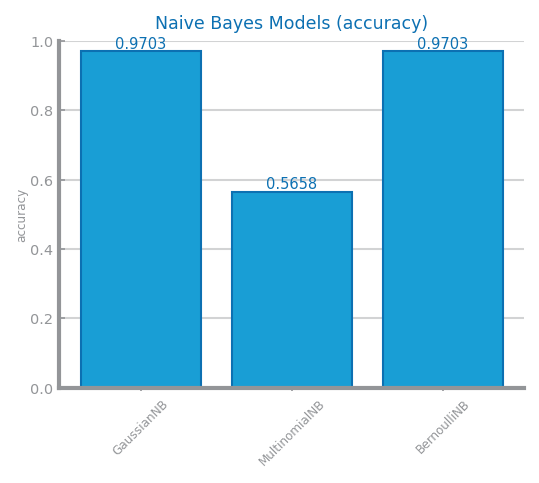

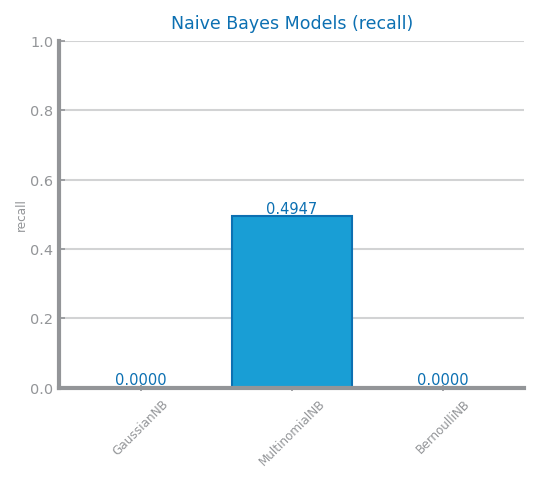

In [27]:
flight_target_train_bin = flight_target_train.astype(int)
flight_target_test_bin = flight_target_test.astype(int)

file_tag = "flights"
eval_metric = "accuracy"

figure()
flight_nb_best_model_acc, flight_nb_params_acc = naive_Bayes_study(
    flight_features_train,
    flight_target_train_bin,
    flight_features_test,
    flight_target_test_bin,
    metric=eval_metric
)
savefig(f"{file_tag}_nb_{eval_metric}_study.png")
show()

figure()
flight_nb_best_model_rec, flight_nb_params_rec = naive_Bayes_study(
    flight_features_train,
    flight_target_train_bin,
    flight_features_test,
    flight_target_test_bin,
    metric="recall"
)
savefig(f"{file_tag}_nb_recall_study.png")
show()

<Figure size 600x450 with 0 Axes>

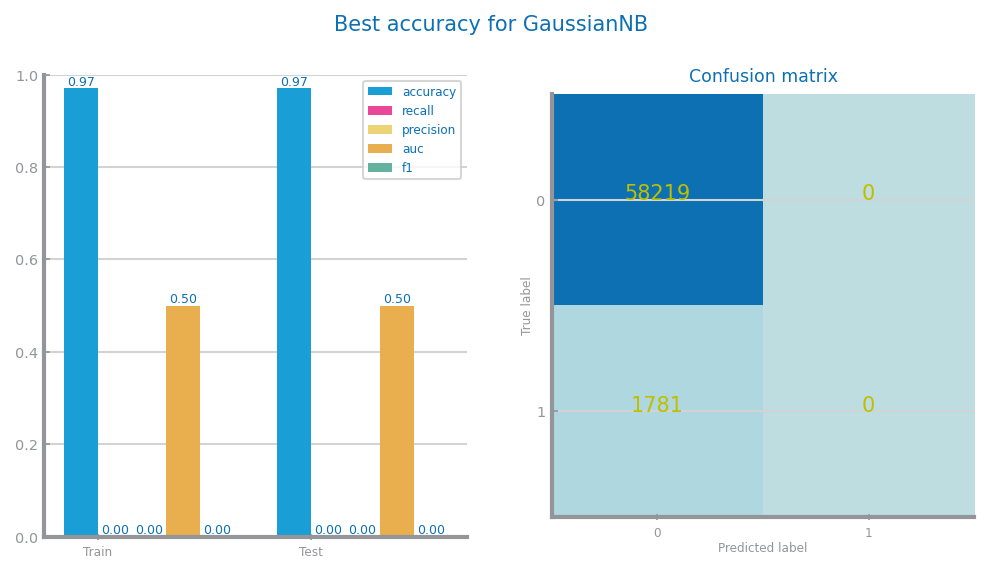

In [28]:
prd_trn_nb_f = flight_nb_best_model_acc.predict(flight_features_train)
prd_tst_nb_f = flight_nb_best_model_acc.predict(flight_features_test)

nb_labels_f = sorted(np.unique(flight_target_train_bin))

figure()
plot_evaluation_results(
    flight_nb_params_acc,
    array(flight_target_train_bin),
    array(prd_trn_nb_f),
    array(flight_target_test_bin),
    array(prd_tst_nb_f),
    nb_labels_f
)
savefig(f'{file_tag}_{flight_nb_params_acc["name"]}_best_{flight_nb_params_acc["metric"]}_eval.png')
show()

**LOGISTIC REGRESSION ANALYSIS - FLIGHT DATA**

/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gargoyle/Library/Python/3.9/lib/python/site-pack

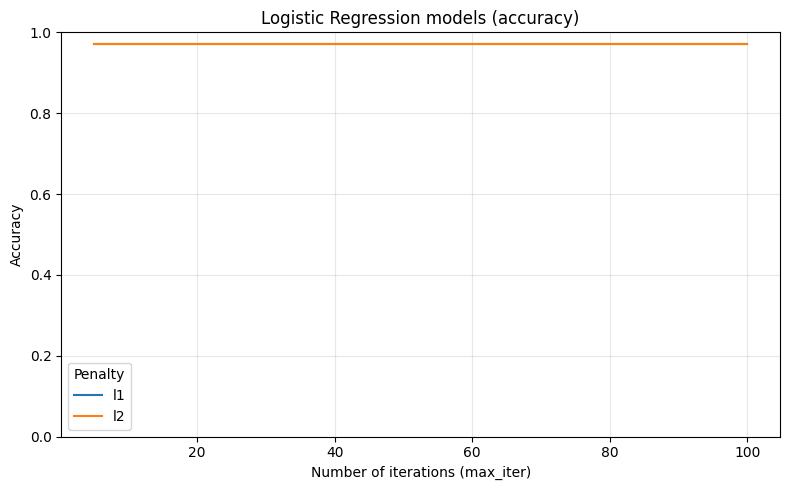


===== Final metrics per penalty (best model for each) =====

Penalty = L1 (best max_iter=5)
Accuracy: 0.9704
Recall: 0.9704
Precision: 0.9713
F1: 0.9559

Penalty = L2 (best max_iter=5)
Accuracy: 0.9703
Recall: 0.9703
Precision: 0.9415
F1: 0.9557


In [21]:
lr_flight_best_models, lr_flight_final_metrics = logistic_regression_study(
    flight_features_train,
    flight_target_train,
    flight_features_test,
    flight_target_test,
    nr_max_iterations=100,
    lag=5
)

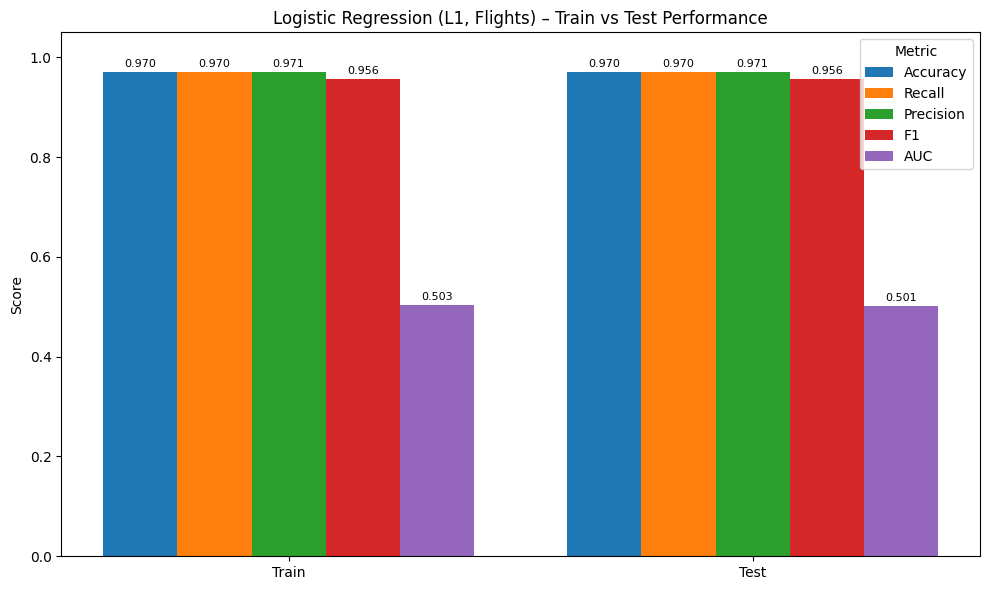

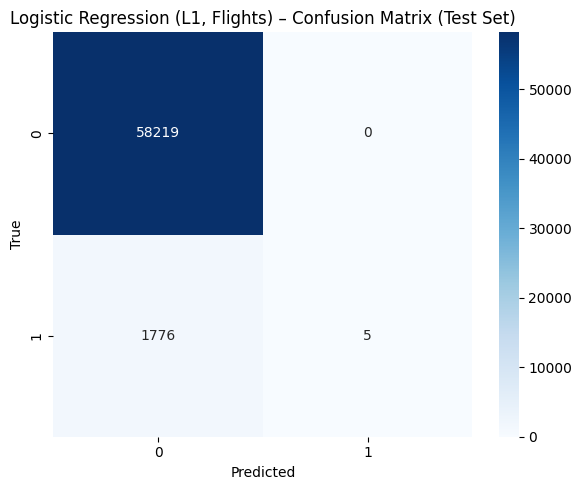

In [22]:
best_lr_flight = lr_flight_best_models["l1"]

pred_train_lr_flight = best_lr_flight.predict(flight_features_train)
pred_test_lr_flight = best_lr_flight.predict(flight_features_test)

lb_lr_flight = LabelBinarizer()
y_train_bin_lr_flight = lb_lr_flight.fit_transform(flight_target_train).ravel()
y_test_bin_lr_flight = lb_lr_flight.transform(flight_target_test).ravel()
pred_train_bin_lr_flight = lb_lr_flight.transform(pred_train_lr_flight).ravel()
pred_test_bin_lr_flight = lb_lr_flight.transform(pred_test_lr_flight).ravel()

lr_flight_train_metrics = {
    "Accuracy": accuracy_score(flight_target_train, pred_train_lr_flight),
    "Recall": recall_score(flight_target_train, pred_train_lr_flight, average="weighted", zero_division=0),
    "Precision": precision_score(flight_target_train, pred_train_lr_flight, average="weighted", zero_division=0),
    "F1": f1_score(flight_target_train, pred_train_lr_flight, average="weighted", zero_division=0),
    "AUC": roc_auc_score(y_train_bin_lr_flight, pred_train_bin_lr_flight),
}

lr_flight_test_metrics = {
    "Accuracy": accuracy_score(flight_target_test, pred_test_lr_flight),
    "Recall": recall_score(flight_target_test, pred_test_lr_flight, average="weighted", zero_division=0),
    "Precision": precision_score(flight_target_test, pred_test_lr_flight, average="weighted", zero_division=0),
    "F1": f1_score(flight_target_test, pred_test_lr_flight, average="weighted", zero_division=0),
    "AUC": roc_auc_score(y_test_bin_lr_flight, pred_test_bin_lr_flight),
}

lr_flight_train_metrics, lr_flight_test_metrics

metrics = list(lr_flight_train_metrics.keys())
train_vals = [lr_flight_train_metrics[m] for m in metrics]
test_vals  = [lr_flight_test_metrics[m] for m in metrics]

groups = np.array([0, 1])
group_labels = ["Train", "Test"]

n_metrics = len(metrics)
group_width = 0.8
bar_width = group_width / n_metrics

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"][:n_metrics]

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    positions = groups - group_width/2 + (i + 0.5) * bar_width
    plt.bar(positions,
            [train_vals[i], test_vals[i]],
            width=bar_width,
            label=metric,
            color=colors[i])
    for x, val in zip(positions, [train_vals[i], test_vals[i]]):
        plt.text(x, val + 0.01, f"{val:.3f}", ha="center", fontsize=8)

plt.xticks(groups, group_labels)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Logistic Regression (L1, Flights) – Train vs Test Performance")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


cm_lr_flight = confusion_matrix(flight_target_test, pred_test_lr_flight)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr_flight, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression (L1, Flights) – Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
